In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
import importlib
import sys
sys.path.append('..')  # Add the parent directory to the Python path
import params
importlib.reload(params)

<module 'params' from 'C:\\Users\\BHARGAV BADE\\Multivar LSTM\\Data\\..\\params.py'>

In [3]:
print(params.lr)

0.001


In [5]:
print(params.n_steps_in)

72


In [6]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [7]:
def load_data_from_csv(data_path):
    return pd.read_csv(data_path)

In [8]:
MAIN_DIR_PATH = '../01_PM2.5 Chinese Weather data'
cities_data_path_list = os.listdir(MAIN_DIR_PATH)

In [9]:
print(*cities_data_path_list, sep='\n')

BeijingPM20100101_20151231.csv
ChengduPM20100101_20151231.csv
GuangzhouPM20100101_20151231.csv
ShanghaiPM20100101_20151231.csv
ShenyangPM20100101_20151231.csv


Beijing city data analysis

In [10]:
sample_data_path = os.path.join(MAIN_DIR_PATH, cities_data_path_list[0])
print(sample_data_path)
data = load_data_from_csv(sample_data_path)

../01_PM2.5 Chinese Weather data\BeijingPM20100101_20151231.csv


In [11]:
data.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


In [12]:
data.shape

(52584, 18)

1. DATA ANALYSIS

1.1 Features present in the Beijing dataset

In [13]:
#statistical information about columns
print(data.describe())

                 No          year         month           day          hour  \
count  52584.000000  52584.000000  52584.000000  52584.000000  52584.000000   
mean   26292.500000   2012.499772      6.523962     15.726609     11.500000   
std    15179.837614      1.707485      3.448452      8.798896      6.922252   
min        1.000000   2010.000000      1.000000      1.000000      0.000000   
25%    13146.750000   2011.000000      4.000000      8.000000      5.750000   
50%    26292.500000   2012.000000      7.000000     16.000000     11.500000   
75%    39438.250000   2014.000000     10.000000     23.000000     17.250000   
max    52584.000000   2015.000000     12.000000     31.000000     23.000000   

             season     PM_Dongsi  PM_Dongsihuan  PM_Nongzhanguan  \
count  52584.000000  25052.000000   20508.000000     24931.000000   
mean       2.491100     89.154439      92.560806        88.643737   
std        1.116988     87.239267      88.027434        88.041166   
min        1

In [14]:
#checking how many null values are in each column
data.isnull().sum()

No                     0
year                   0
month                  0
day                    0
hour                   0
season                 0
PM_Dongsi          27532
PM_Dongsihuan      32076
PM_Nongzhanguan    27653
PM_US Post          2197
DEWP                   5
HUMI                 339
PRES                 339
TEMP                   5
cbwd                   5
Iws                    5
precipitation        484
Iprec                484
dtype: int64

In [15]:
# Here are the features we have
for idx, col in enumerate(data.columns):
    print(idx + 1, col)

1 No
2 year
3 month
4 day
5 hour
6 season
7 PM_Dongsi
8 PM_Dongsihuan
9 PM_Nongzhanguan
10 PM_US Post
11 DEWP
12 HUMI
13 PRES
14 TEMP
15 cbwd
16 Iws
17 precipitation
18 Iprec


1.2 Find NaN values columns and analyze them

In [16]:
for col in data.columns:
    if data[col].isnull().any():
        print(col)

PM_Dongsi
PM_Dongsihuan
PM_Nongzhanguan
PM_US Post
DEWP
HUMI
PRES
TEMP
cbwd
Iws
precipitation
Iprec


Our target feature is PM2.5, which we must predict using the LSTM network. But we have rows with NaN PM values. What I decided to do is remove all PM-like columns and create one PM column.
Since we have 4 PM values in each row, firstly we need to find the rows with 4 NAN values in the row and remove them. 
Ex: (PM_Dongsi, PM_Dongsihuan, PM_Nongzhanguan, PM_US Post) == (NaN, NaN, NaN, NaN) ---> remove row

In [17]:
def get_pm_columns(data_frame):
    cols = list(data_frame.columns)
    pm_cols = []
    for col in cols:
        if col.startswith('PM'):
            pm_cols.append(col)
    return pm_cols 

In [18]:
data.shape

(52584, 18)

In [19]:
pm_cols = get_pm_columns(data)
all_nan_pm_rows_indexes = []
(n_rows, n_cols) = data.shape
for idx, (index, row) in enumerate(data.iterrows()):
    if row[pm_cols].isnull().all(): # .all()
        all_nan_pm_rows_indexes.append(index)
    
    if (idx + 1) % 5000 == 0:
        print(idx + 1, ' / ', n_rows)

5000  /  52584
10000  /  52584
15000  /  52584
20000  /  52584
25000  /  52584
30000  /  52584
35000  /  52584
40000  /  52584
45000  /  52584
50000  /  52584


In [20]:
print('Number of all PM NaN rows', len(all_nan_pm_rows_indexes))

Number of all PM NaN rows 1894


I build correlation matrix to check for linear relationship between the variables. The heatmap I generate provides a quick overview of how variables in the dataset relate to one another, which can be very useful for further data analysis or modeling.

In [21]:
import seaborn as sns

# Step 1: Exclude non-numeric columns
numeric_data = data.select_dtypes(include=[float, int])

# Step 2: Calculate the correlation matrix for numeric data only
corr = numeric_data.corr()

# Step 3: Styling and visualizing the correlation matrix
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

# Use .format() instead of .set_precision()
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magnify")\
    .format(precision=2)\
    .set_table_styles(magnify())

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec
No,1.00,0.99,0.17,0.02,0.00,0.03,-0.04,-0.02,-0.02,-0.05,0.07,0.02,-0.01,0.07,-0.06,0.01,0.01
year,0.99,1.00,0.00,-0.00,-0.00,-0.00,-0.03,-0.01,-0.02,-0.05,0.03,-0.02,-0.01,0.05,-0.06,0.01,0.01
month,0.17,0.00,1.00,0.01,0.00,0.21,-0.06,-0.03,-0.03,-0.01,0.25,0.22,-0.05,0.16,0.01,0.01,0.01
day,0.02,-0.00,0.01,1.00,-0.00,-0.01,0.07,0.06,0.07,0.08,0.04,0.04,-0.00,0.02,-0.02,-0.00,-0.00
hour,0.00,-0.00,0.00,-0.00,1.00,-0.00,0.02,-0.03,-0.01,0.00,-0.02,-0.26,-0.04,0.15,0.06,0.00,0.00
season,0.03,-0.00,0.21,-0.01,-0.00,1.00,0.13,0.11,0.17,0.13,-0.42,0.03,0.57,-0.57,0.04,0.00,0.00
PM_Dongsi,-0.04,-0.03,-0.06,0.07,0.02,0.13,1.00,0.93,0.96,0.96,0.10,0.38,0.03,-0.17,-0.22,-0.01,-0.01
PM_Dongsihuan,-0.02,-0.01,-0.03,0.06,-0.03,0.11,0.93,1.00,0.96,0.95,0.10,0.39,0.04,-0.18,-0.23,-0.03,-0.05
PM_Nongzhanguan,-0.02,-0.02,-0.03,0.07,-0.01,0.17,0.96,0.96,1.00,0.97,0.06,0.38,0.07,-0.21,-0.22,-0.01,-0.01
PM_US Post,-0.05,-0.05,-0.01,0.08,0.00,0.13,0.96,0.95,0.97,1.00,0.13,0.42,-0.02,-0.13,-0.24,-0.00,-0.00


Yes. We found the relationship between several variables. 
TEMP and PRES show a strong negative correlation. This suggests that as the temperature increases, pressure tends to decrease, which is a common atmospheric relationship.
There's a moderate positive correlation between DEWP and HUMI. Dew point and humidity are related because both are measures of moisture in the air. A higher dew point indicates more moisture, which generally correlates with higher humidity. However, the relationship is not perfect, as other factors like temperature and pressure also influence humidity.

Since DEWP HUMI PRES TEMP showing good to moderate coorelation between them, they could play a huge role while training the model.
Let us look for any NaN values in these columns.

In [223]:
dhpt_cols = ['DEWP', 'HUMI', 'PRES', 'TEMP']
any_nan_dhpt_rows_indexes = []

for idx, (index, row) in enumerate(data.iterrows()):
    if row[dhpt_cols].isnull().any(): #.any()
        any_nan_dhpt_rows_indexes.append(index)
    
    if (idx + 1) % 5000 == 0:
        print(idx + 1, ' / ', n_rows)

5000  /  52584
10000  /  52584
15000  /  52584
20000  /  52584
25000  /  52584
30000  /  52584
35000  /  52584
40000  /  52584
45000  /  52584
50000  /  52584


In [224]:
print('Number of any of DEWP HUMI PRES TEMP NaN rows', len(any_nan_dhpt_rows_indexes))

Number of any of DEWP HUMI PRES TEMP NaN rows 339


Let us create a single PM column to replace the four PM columns we have for each time stamp

In [225]:
def get_pm_columns(data_frame):
    cols = list(data_frame.columns)
    pm_cols = []
    for col in cols:
        if col.startswith('PM'):
            pm_cols.append(col)
    return pm_cols 

def get_main_features_columns(data_frame):
    cols = list(data_frame.columns)
    features_cols = []
    for col in cols:
        if not col.startswith('PM'):
            features_cols.append(col)
    return features_cols

In [226]:
pm_cols = get_pm_columns(data)
features_columns = get_main_features_columns(data)
features_columns.append('PM')

In [227]:
features_columns

['No',
 'year',
 'month',
 'day',
 'hour',
 'season',
 'DEWP',
 'HUMI',
 'PRES',
 'TEMP',
 'cbwd',
 'Iws',
 'precipitation',
 'Iprec',
 'PM']

In [228]:
# Ensure 'PM' is not in features_columns already
features_columns = [col for col in features_columns if col != 'PM']

new_data_rows_list = []
for idx, (index, row) in enumerate(data.iterrows()):
    mn = row[pm_cols].mean()
    if not math.isnan(mn):
        temp_row = {col: row[col] for col in features_columns}
        temp_row['PM'] = mn

        new_data_rows_list.append(temp_row)

    if idx % 1000 == 0 and idx != 0:
        print(idx)

# Convert the list of dictionaries into a DataFrame
new_data = pd.DataFrame(new_data_rows_list)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000


In [229]:
new_data.shape

(50690, 15)

In [230]:
new_data.head()


,No,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,PM
0,24,2010,1,1,23,4,-17.0,41.0,1020.0,-5.0,cv,0.89,0.0,0.0,129.0
1,25,2010,1,2,0,4,-16.0,38.0,1020.0,-4.0,SE,1.79,0.0,0.0,148.0
2,26,2010,1,2,1,4,-15.0,42.0,1020.0,-4.0,SE,2.68,0.0,0.0,159.0
3,27,2010,1,2,2,4,-11.0,63.5,1021.0,-5.0,SE,3.57,0.0,0.0,181.0
4,28,2010,1,2,3,4,-7.0,85.0,1022.0,-5.0,SE,5.36,0.0,0.0,138.0


In [231]:
dhpt_cols = ['DEWP', 'HUMI', 'PRES', 'TEMP']
any_nan_dhpt_rows_indexess = []

for idx, (index, row) in enumerate(new_data.iterrows()):
    if row[dhpt_cols].isnull().any(): #.any()
        any_nan_dhpt_rows_indexess.append(index)
    
    if (idx + 1) % 5000 == 0:
        print(idx + 1, ' / ', n_rows)

5000  /  52584
10000  /  52584
15000  /  52584
20000  /  52584
25000  /  52584
30000  /  52584
35000  /  52584
40000  /  52584
45000  /  52584
50000  /  52584


In [232]:
print('Number of any of DEWP HUMI PRES TEMP NaN rows', len(any_nan_dhpt_rows_indexes))

Number of any of DEWP HUMI PRES TEMP NaN rows 339


We have timestamp information in 4 different columns. We need to covert it into single column and place it in the second column.

In [233]:
new_data['datetime'] = pd.to_datetime(new_data[['year', 'month', 'day', 'hour']])

new_data.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)

# Reorder columns to place 'datetime' as the second column
# First get the list of columns
columns = list(new_data.columns)

# Place 'datetime' as the second column and keep the rest of the columns in their current order
new_column_order = ['No', 'datetime'] + [col for col in columns if col not in ['No', 'datetime']]

# Reorder DataFrame columns
new_data = new_data[new_column_order]

In [234]:
new_data.head()

,No,datetime,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,PM
0,24,2010-01-01 23:00:00,4,-17.0,41.0,1020.0,-5.0,cv,0.89,0.0,0.0,129.0
1,25,2010-01-02 00:00:00,4,-16.0,38.0,1020.0,-4.0,SE,1.79,0.0,0.0,148.0
2,26,2010-01-02 01:00:00,4,-15.0,42.0,1020.0,-4.0,SE,2.68,0.0,0.0,159.0
3,27,2010-01-02 02:00:00,4,-11.0,63.5,1021.0,-5.0,SE,3.57,0.0,0.0,181.0
4,28,2010-01-02 03:00:00,4,-7.0,85.0,1022.0,-5.0,SE,5.36,0.0,0.0,138.0


In [235]:
new_data.isnull().sum()

No                 0
datetime           0
season             0
DEWP               5
HUMI             339
PRES             339
TEMP               5
cbwd               5
Iws                5
precipitation    484
Iprec            484
PM                 0
dtype: int64

Let us plot PM against datetime to understand the nature of PM throughout the dataset.

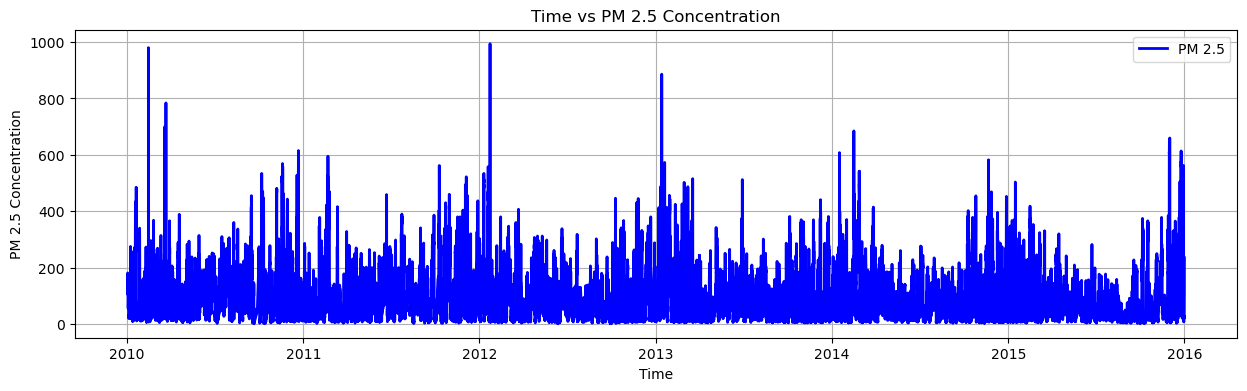

In [236]:
plt.figure(figsize=(15, 4))
plt.plot(new_data['datetime'], new_data['PM'], label='PM 2.5', color='b', linewidth=2)
plt.xlabel('Time')
plt.ylabel('PM 2.5 Concentration')
plt.title('Time vs PM 2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()

Let us plot PM for each year seperately to understand it in more detail.

[2010 2011 2012 2013 2014 2015]


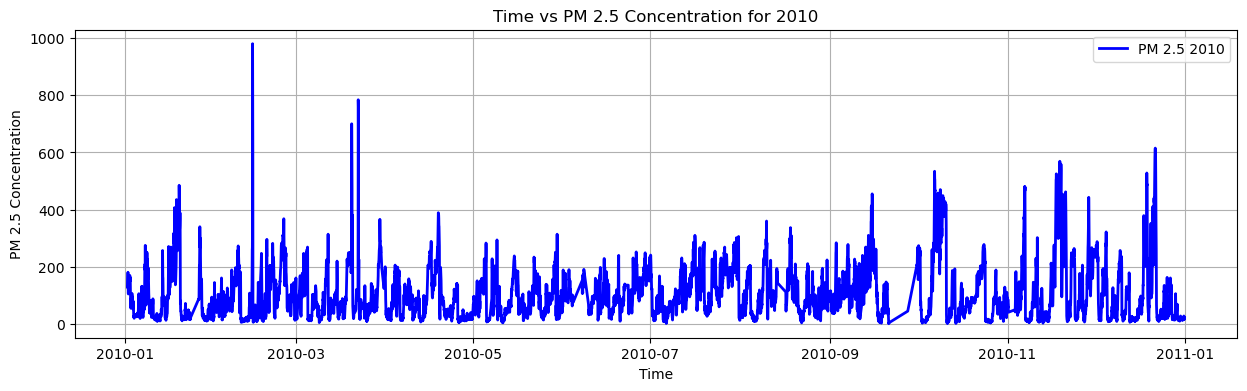

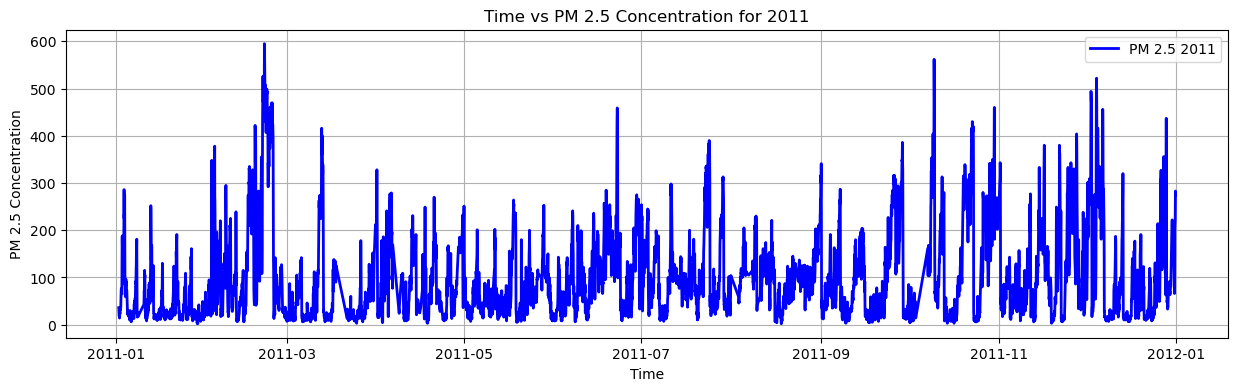

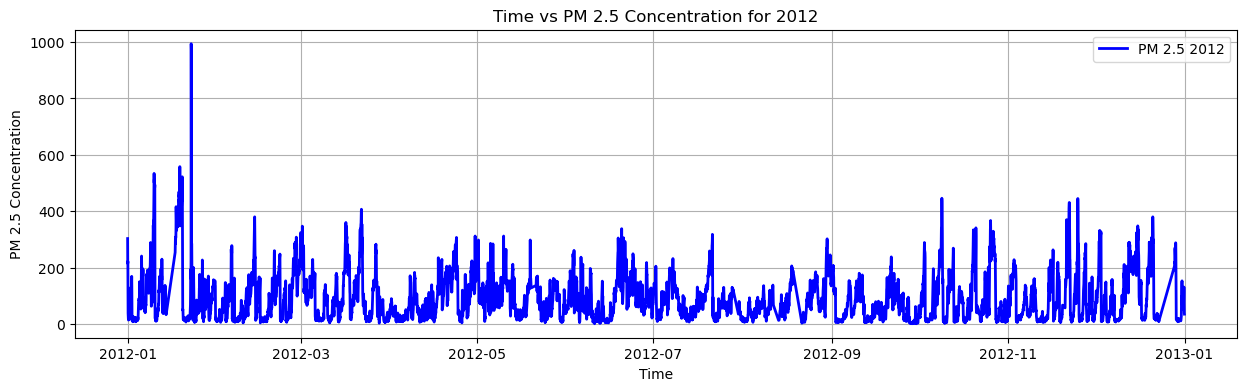

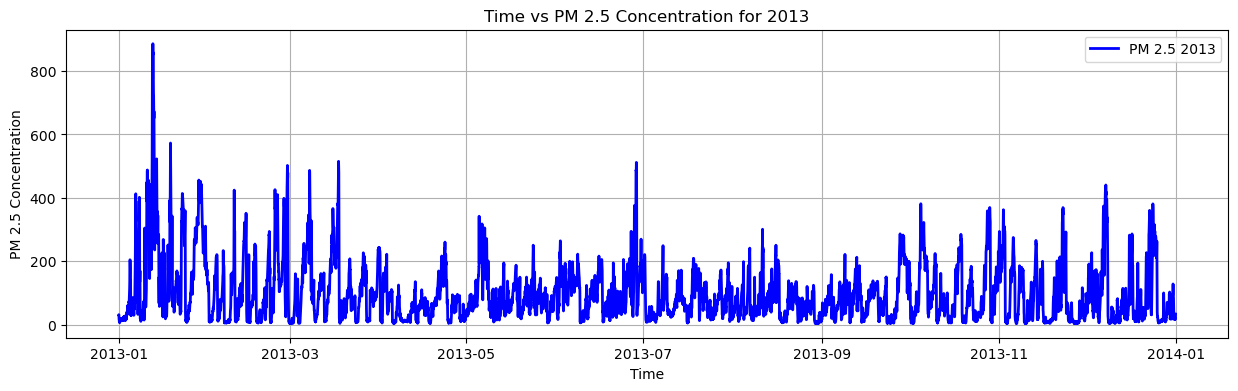

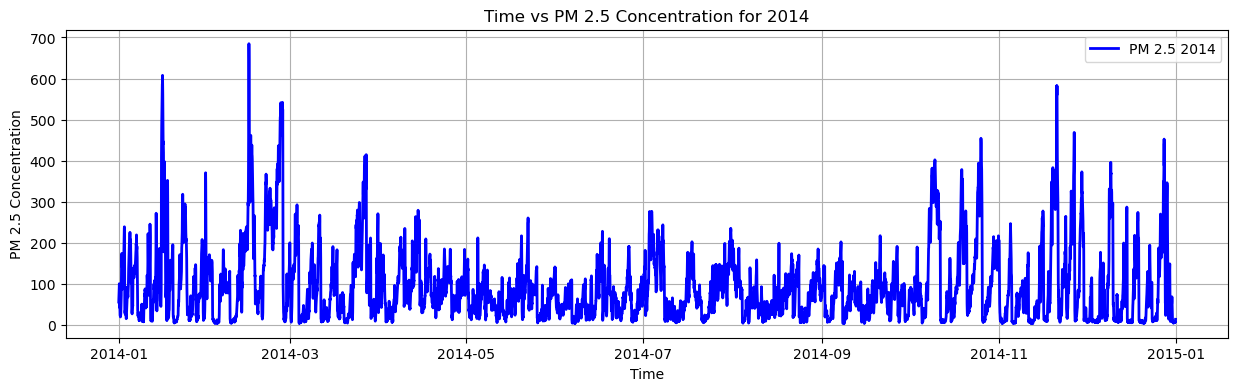

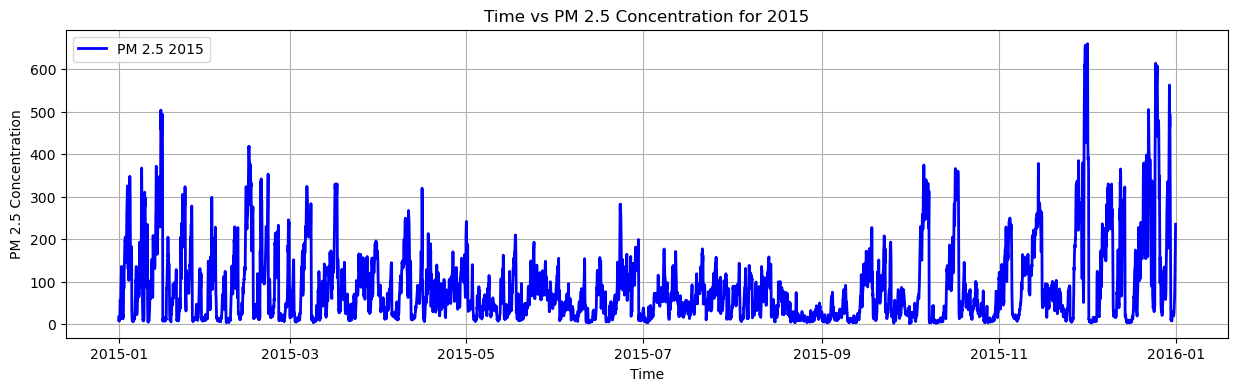

In [237]:
# Define the range of years you want to plot
years = new_data['datetime'].dt.year.unique()
print(years)

# Create a plot for each year
for year in years:
    subset_data = new_data[new_data['datetime'].dt.year == year]
    
    plt.figure(figsize=(15, 4))
    plt.plot(subset_data['datetime'], subset_data['PM'], label=f'PM 2.5 {year}', color='b', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('PM 2.5 Concentration')
    plt.title(f'Time vs PM 2.5 Concentration for {year}')
    plt.legend()
    plt.grid(True)
    plt.show()

Let us plot dew point (Celsius Degree) against datetime to understand the nature of dew along the time.

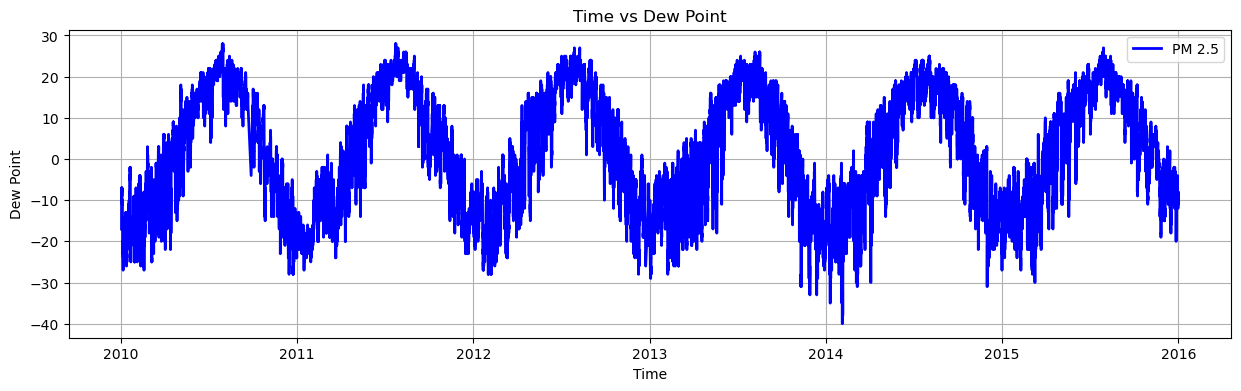

In [238]:
plt.figure(figsize=(15, 4))
plt.plot(new_data['datetime'], new_data['DEWP'], label='PM 2.5', color='b', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Dew Point')
plt.title('Time vs Dew Point')
plt.legend()
plt.grid(True)
plt.show()

Let us plot pressure against datetime to understand the nature of pressure along the time.

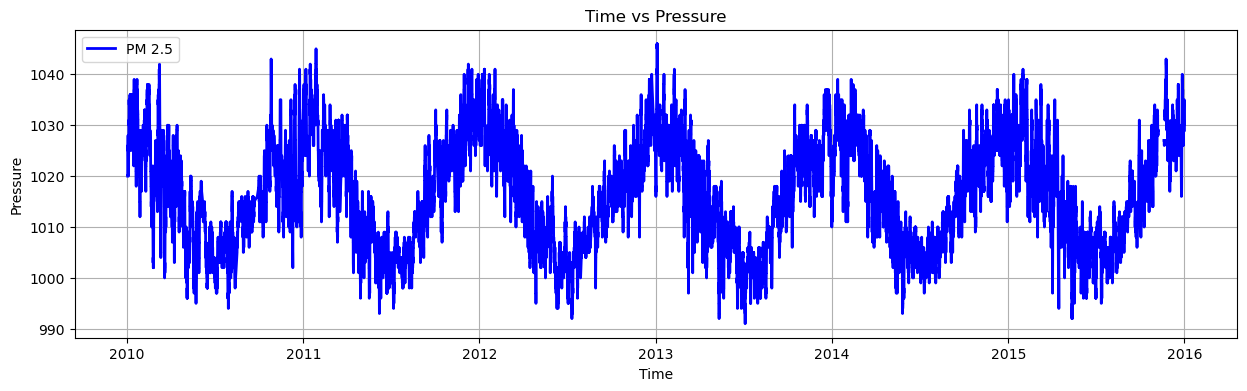

In [239]:
plt.figure(figsize=(15, 4))
plt.plot(new_data['datetime'], new_data['PRES'], label='PM 2.5', color='b', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Pressure')
plt.title('Time vs Pressure')
plt.legend()
plt.grid(True)
plt.show()

Let us plot temperature against datetime to understand the nature of temperature through the all timestamps.

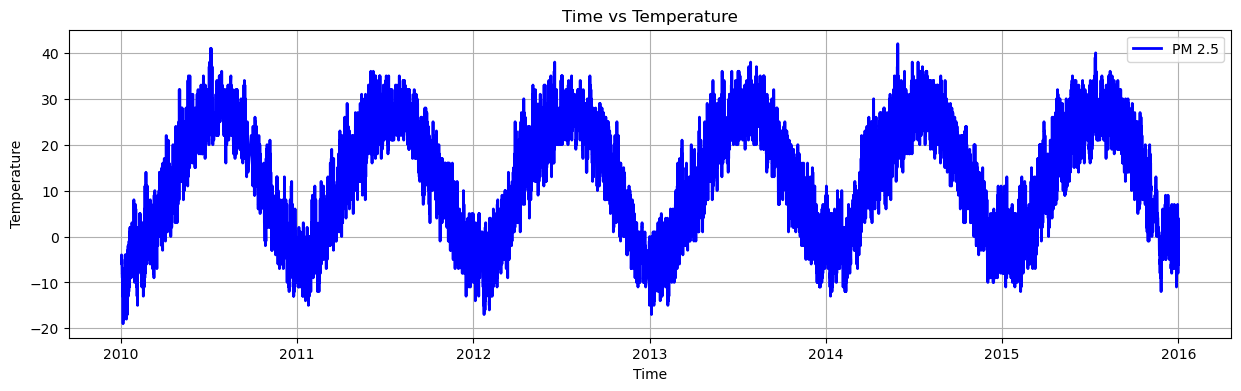

In [240]:
plt.figure(figsize=(15, 4))
plt.plot(new_data['datetime'], new_data['TEMP'], label='PM 2.5', color='b', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Time vs Temperature')
plt.legend()
plt.grid(True)
plt.show()

Let us plot humidity against datetime to understand the nature of humidity throughout the dataset.

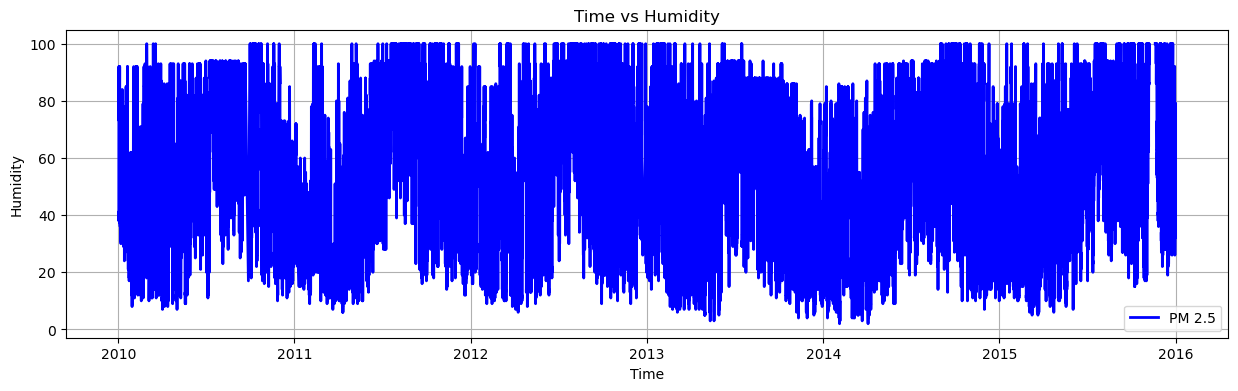

In [241]:
plt.figure(figsize=(15, 4))
plt.plot(new_data['datetime'], new_data['HUMI'], label='PM 2.5', color='b', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.title('Time vs Humidity')
plt.legend()
plt.grid(True)
plt.show()

Let us plot Precipitation against datetime to understand the nature of humidity throughout the dataset.

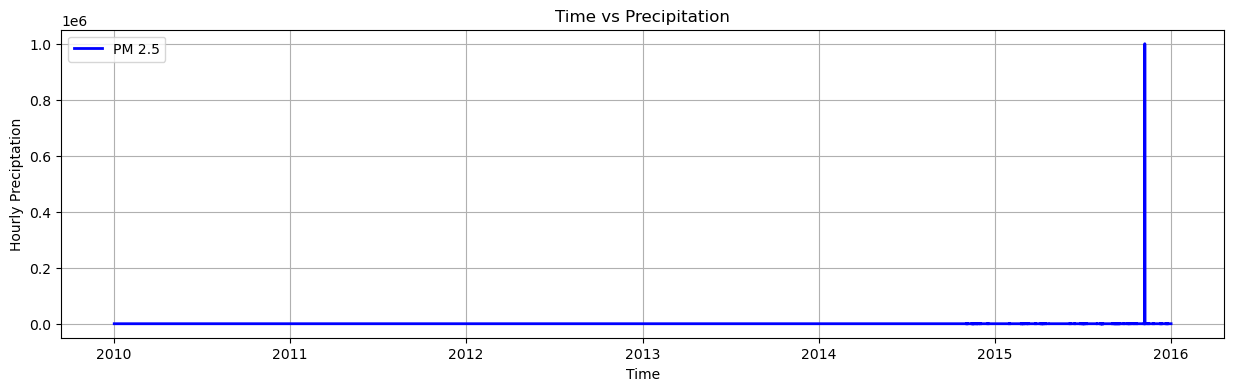

In [242]:
plt.figure(figsize=(15, 4))
plt.plot(new_data['datetime'], new_data['precipitation'], label='PM 2.5', color='b', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Hourly Preciptation')
plt.title('Time vs Precipitation')
plt.legend()
plt.grid(True)
plt.show()

Let us plot cumulated precipitation against datetime to understand the nature of humidity throughout the dataset.

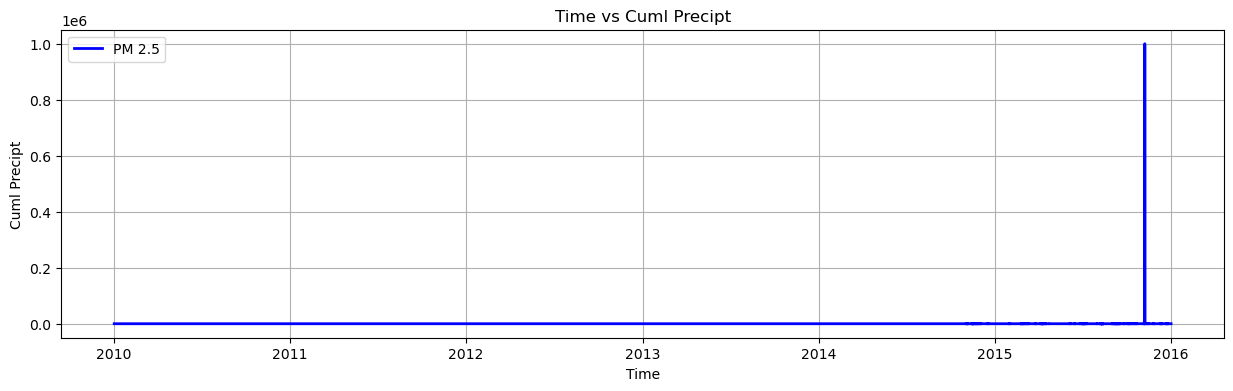

In [243]:
plt.figure(figsize=(15, 4))
plt.plot(new_data['datetime'], new_data['Iprec'], label='PM 2.5', color='b', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Cuml Precipt')
plt.title('Time vs Cuml Precipt')
plt.legend()
plt.grid(True)
plt.show()

Sum of the NaN indices in each column.

In [244]:
new_data.isnull().sum()

No                 0
datetime           0
season             0
DEWP               5
HUMI             339
PRES             339
TEMP               5
cbwd               5
Iws                5
precipitation    484
Iprec            484
PM                 0
dtype: int64

Finding indices of the NaNs in the 'DEWP','HUMI',"PRES','TEMP', 'lws','precipitation' and 'Iprec' columns.

In [245]:
# Find indices of the features where it is NaN
nan_indices_dewp = new_data[new_data['DEWP'].isna()].index
nan_indices_humi = new_data[new_data['HUMI'].isna()].index
nan_indices_pres = new_data[new_data['PRES'].isna()].index
nan_indices_temp = new_data[new_data['TEMP'].isna()].index
nan_indices_Iws = new_data[new_data['Iws'].isna()].index
nan_indices_precip = new_data[new_data['precipitation'].isna()].index
nan_indices_Iprec = new_data[new_data['Iprec'].isna()].index

# Print the indices and sum of the NaNs in each column
print("DEWP nan_indices are:", nan_indices_dewp)
print("HUMI nan_indices are:", nan_indices_humi)
print("PRES nan_indices are:", nan_indices_pres)
print("TEMP nan_indices are:", nan_indices_temp)
print("Iws nan_indices are:", nan_indices_Iws)
print("Precipitation nan_indices are:", nan_indices_precip)
print("Iprec nan_indices are:", nan_indices_Iprec)


DEWP nan_indices are: Index([44028, 46060, 47377, 49434, 49997], dtype='int64')
HUMI nan_indices are: Index([44028, 46060, 47377, 49363, 49364, 49365, 49366, 49367, 49368, 49369,
       ...
       49706, 49707, 49708, 49709, 49710, 49711, 49712, 49713, 49714, 49997],
      dtype='int64', length=339)
PRES nan_indices are: Index([44028, 46060, 47377, 49363, 49364, 49365, 49366, 49367, 49368, 49369,
       ...
       49706, 49707, 49708, 49709, 49710, 49711, 49712, 49713, 49714, 49997],
      dtype='int64', length=339)
TEMP nan_indices are: Index([44028, 46060, 47377, 49434, 49997], dtype='int64')
Iws nan_indices are: Index([44028, 46060, 47377, 49434, 49997], dtype='int64')
Precipitation nan_indices are: Index([40530, 40543, 40790, 40814, 40862, 40886, 41005, 41006, 41007, 41008,
       ...
       50441, 50442, 50443, 50444, 50445, 50446, 50447, 50448, 50479, 50514],
      dtype='int64', length=484)
Iprec nan_indices are: Index([40530, 40543, 40790, 40814, 40862, 40886, 41005, 41006, 410

Converting "cbwd" text into numericals using one-hot embedding

In [246]:
# Perform one-hot encoding on the 'cbwd' column
df_encoded = pd.get_dummies(new_data, columns=['cbwd'], prefix='cbwd')

# Drop rows where any of the one-hot encoded columns are NaN (this will handle the 'cv' or any other NaN-like values)
df_encoded = df_encoded.dropna(subset=[col for col in df_encoded.columns if 'cbwd_' in col])

# Display the first few rows of the one-hot encoded DataFrame
df_encoded.head()

,No,datetime,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
0,24,2010-01-01 23:00:00,4,-17.0,41.0,1020.0,-5.0,0.89,0.0,0.0,129.0,False,False,False,True
1,25,2010-01-02 00:00:00,4,-16.0,38.0,1020.0,-4.0,1.79,0.0,0.0,148.0,False,False,True,False
2,26,2010-01-02 01:00:00,4,-15.0,42.0,1020.0,-4.0,2.68,0.0,0.0,159.0,False,False,True,False
3,27,2010-01-02 02:00:00,4,-11.0,63.5,1021.0,-5.0,3.57,0.0,0.0,181.0,False,False,True,False
4,28,2010-01-02 03:00:00,4,-7.0,85.0,1022.0,-5.0,5.36,0.0,0.0,138.0,False,False,True,False


In [247]:
# Perform one-hot encoding on the 'cbwd' column
df_encoded = pd.get_dummies(new_data, columns=['cbwd'], prefix='cbwd')

# Replace NaN values with 0
df_encoded = df_encoded.fillna(0)

# Exclude the 'datetime' column from conversion and keep it in its original form
# Check if there is a datetime column and keep it unchanged
if 'datetime' in df_encoded.columns:
    datetime_col = df_encoded['datetime']  # Store datetime column separately

# Convert all other columns to int32
#df_encoded = df_encoded.drop('datetime', axis=1).astype(np.int32, errors='ignore')

# Add the 'datetime' column back to the DataFrame
df_encoded['datetime'] = datetime_col

# Display the first few rows of the DataFrame with the datetime column
df_encoded.head()

,No,datetime,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
0,24,2010-01-01 23:00:00,4,-17.0,41.0,1020.0,-5.0,0.89,0.0,0.0,129.0,False,False,False,True
1,25,2010-01-02 00:00:00,4,-16.0,38.0,1020.0,-4.0,1.79,0.0,0.0,148.0,False,False,True,False
2,26,2010-01-02 01:00:00,4,-15.0,42.0,1020.0,-4.0,2.68,0.0,0.0,159.0,False,False,True,False
3,27,2010-01-02 02:00:00,4,-11.0,63.5,1021.0,-5.0,3.57,0.0,0.0,181.0,False,False,True,False
4,28,2010-01-02 03:00:00,4,-7.0,85.0,1022.0,-5.0,5.36,0.0,0.0,138.0,False,False,True,False


drop "cbwd_cv" from the dataframe (this is a column for NaN values which does not carry any weight)

In [248]:
# Drop a specific column, e.g., 'cbwd_SE'
df_encoded = df_encoded.drop(columns=['cbwd_cv'])

# Display the first few rows to confirm the column is dropped
df_encoded.head()

,No,datetime,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM,cbwd_NE,cbwd_NW,cbwd_SE
0,24,2010-01-01 23:00:00,4,-17.0,41.0,1020.0,-5.0,0.89,0.0,0.0,129.0,False,False,False
1,25,2010-01-02 00:00:00,4,-16.0,38.0,1020.0,-4.0,1.79,0.0,0.0,148.0,False,False,True
2,26,2010-01-02 01:00:00,4,-15.0,42.0,1020.0,-4.0,2.68,0.0,0.0,159.0,False,False,True
3,27,2010-01-02 02:00:00,4,-11.0,63.5,1021.0,-5.0,3.57,0.0,0.0,181.0,False,False,True
4,28,2010-01-02 03:00:00,4,-7.0,85.0,1022.0,-5.0,5.36,0.0,0.0,138.0,False,False,True


Convert "cbwd_" features into numericals.

In [249]:
# Assuming 'df' is your DataFrame and you want to apply it to multiple columns
columns_to_convert = ['cbwd_NE', 'cbwd_NW', 'cbwd_SE']  # List of columns that need conversion

for col in columns_to_convert:
    df_encoded[col] = df_encoded[col].replace({'True': 1, 'False': 0}).astype(int)

# Display the updated DataFrame
df_encoded.head()

,No,datetime,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM,cbwd_NE,cbwd_NW,cbwd_SE
0,24,2010-01-01 23:00:00,4,-17.0,41.0,1020.0,-5.0,0.89,0.0,0.0,129.0,0,0,0
1,25,2010-01-02 00:00:00,4,-16.0,38.0,1020.0,-4.0,1.79,0.0,0.0,148.0,0,0,1
2,26,2010-01-02 01:00:00,4,-15.0,42.0,1020.0,-4.0,2.68,0.0,0.0,159.0,0,0,1
3,27,2010-01-02 02:00:00,4,-11.0,63.5,1021.0,-5.0,3.57,0.0,0.0,181.0,0,0,1
4,28,2010-01-02 03:00:00,4,-7.0,85.0,1022.0,-5.0,5.36,0.0,0.0,138.0,0,0,1


In [250]:
df_encoded.isnull().sum()

No               0
datetime         0
season           0
DEWP             0
HUMI             0
PRES             0
TEMP             0
Iws              0
precipitation    0
Iprec            0
PM               0
cbwd_NE          0
cbwd_NW          0
cbwd_SE          0
dtype: int64

In [251]:
df_encoded.shape

(50690, 14)

In [252]:
df = df_encoded

In [253]:
df.head()

,No,datetime,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM,cbwd_NE,cbwd_NW,cbwd_SE
0,24,2010-01-01 23:00:00,4,-17.0,41.0,1020.0,-5.0,0.89,0.0,0.0,129.0,0,0,0
1,25,2010-01-02 00:00:00,4,-16.0,38.0,1020.0,-4.0,1.79,0.0,0.0,148.0,0,0,1
2,26,2010-01-02 01:00:00,4,-15.0,42.0,1020.0,-4.0,2.68,0.0,0.0,159.0,0,0,1
3,27,2010-01-02 02:00:00,4,-11.0,63.5,1021.0,-5.0,3.57,0.0,0.0,181.0,0,0,1
4,28,2010-01-02 03:00:00,4,-7.0,85.0,1022.0,-5.0,5.36,0.0,0.0,138.0,0,0,1


Exclude No column from the dataframe. It does not carry any weight in the dataframe.

In [254]:
data = df.drop(['No'], axis=1)

In [255]:
data.head()

,datetime,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM,cbwd_NE,cbwd_NW,cbwd_SE
0,2010-01-01 23:00:00,4,-17.0,41.0,1020.0,-5.0,0.89,0.0,0.0,129.0,0,0,0
1,2010-01-02 00:00:00,4,-16.0,38.0,1020.0,-4.0,1.79,0.0,0.0,148.0,0,0,1
2,2010-01-02 01:00:00,4,-15.0,42.0,1020.0,-4.0,2.68,0.0,0.0,159.0,0,0,1
3,2010-01-02 02:00:00,4,-11.0,63.5,1021.0,-5.0,3.57,0.0,0.0,181.0,0,0,1
4,2010-01-02 03:00:00,4,-7.0,85.0,1022.0,-5.0,5.36,0.0,0.0,138.0,0,0,1


In [256]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50690 entries, 0 to 50689
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       50690 non-null  datetime64[ns]
 1   season         50690 non-null  int64         
 2   DEWP           50690 non-null  float64       
 3   HUMI           50690 non-null  float64       
 4   PRES           50690 non-null  float64       
 5   TEMP           50690 non-null  float64       
 6   Iws            50690 non-null  float64       
 7   precipitation  50690 non-null  float64       
 8   Iprec          50690 non-null  float64       
 9   PM             50690 non-null  float64       
 10  cbwd_NE        50690 non-null  int32         
 11  cbwd_NW        50690 non-null  int32         
 12  cbwd_SE        50690 non-null  int32         
dtypes: datetime64[ns](1), float64(8), int32(3), int64(1)
memory usage: 4.4 MB


From above, it is clear that our data (50690, 16) is now clean without any NaNs. However, the "datetime" column is of the "datetime64[ns]" Dtype, which is not feasible for us in the future.

We need to seperate year, month, day and hour from the "datetime" column to have only int or float type data in the dataframe

In [257]:
# Create separate columns for year, month, day, and hour, ensuring they are of type int64

data['year'] = data['datetime'].dt.year.astype('int64')
data['month'] = data['datetime'].dt.month.astype('int64')
data['day'] = data['datetime'].dt.day.astype('int64')
data['hour'] = data['datetime'].dt.hour.astype('int64')

# Drop the 'datetime' column as it's no longer needed
data = data.drop(columns=['datetime'])

# Reorder the columns: move 'year', 'month', 'day', 'hour' to the front
cols = ['year', 'month', 'day', 'hour'] + [col for col in data.columns if col not in ['year', 'month', 'day', 'hour']]

# Apply the new column order to the DataFrame
data = data[cols]

In [258]:
data.head()

,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM,cbwd_NE,cbwd_NW,cbwd_SE
0,2010,1,1,23,4,-17.0,41.0,1020.0,-5.0,0.89,0.0,0.0,129.0,0,0,0
1,2010,1,2,0,4,-16.0,38.0,1020.0,-4.0,1.79,0.0,0.0,148.0,0,0,1
2,2010,1,2,1,4,-15.0,42.0,1020.0,-4.0,2.68,0.0,0.0,159.0,0,0,1
3,2010,1,2,2,4,-11.0,63.5,1021.0,-5.0,3.57,0.0,0.0,181.0,0,0,1
4,2010,1,2,3,4,-7.0,85.0,1022.0,-5.0,5.36,0.0,0.0,138.0,0,0,1


In [259]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50690 entries, 0 to 50689
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           50690 non-null  int64  
 1   month          50690 non-null  int64  
 2   day            50690 non-null  int64  
 3   hour           50690 non-null  int64  
 4   season         50690 non-null  int64  
 5   DEWP           50690 non-null  float64
 6   HUMI           50690 non-null  float64
 7   PRES           50690 non-null  float64
 8   TEMP           50690 non-null  float64
 9   Iws            50690 non-null  float64
 10  precipitation  50690 non-null  float64
 11  Iprec          50690 non-null  float64
 12  PM             50690 non-null  float64
 13  cbwd_NE        50690 non-null  int32  
 14  cbwd_NW        50690 non-null  int32  
 15  cbwd_SE        50690 non-null  int32  
dtypes: float64(8), int32(3), int64(5)
memory usage: 5.6 MB


We are done with the data cleaning part. Now let us split and standardize the dataset to make it model-ready.

DATA SPLITTING

In [260]:
from sklearn.model_selection import train_test_split

In [261]:
#train_set, test_set = train_test_split(data, test_size=0.2,shuffle=False, random_state=42)
#print('Train instances:', len(train_set), '\nTest instances: ', len(test_set))

In [262]:
#Splitting the data for having training set as 60% of the data
train_set, remaining_set = train_test_split(data, test_size=0.4,shuffle=False, random_state=42)
print('Train instances:', len(train_set), '\nremaining instances: ', len(remaining_set))

Train instances: 30414 
remaining instances:  20276


In [263]:
#Splitting the data for having testing set as 30% of the data and 10% as validation set
val_set, test_set = train_test_split(remaining_set, test_size=0.75,shuffle=False, random_state=42)
print('Test instances:', len(test_set), '\nValidation instances: ', len(val_set))

Test instances: 15207 
Validation instances:  5069


In [264]:
train_set.shape

(30414, 16)

In [265]:
test_set.shape

(15207, 16)

In [266]:
val_set.shape

(5069, 16)

DATA STANDARDIZATION

In [267]:
scaler = StandardScaler()

# Example columns to exclude from standardization
exclude_cols = ['year', 'month', 'day', 'hour', 'season']

pm_column = 'PM'

#FOR TRAIN SET
# Selecting the numerical columns (excluding the ones you want to keep unchanged)
num_cols = train_set.select_dtypes(include=[np.number]).columns.difference(exclude_cols)
pm_index = num_cols.get_loc(pm_column)  # Get the index of PM in the num_cols

# Fit and transform only on train numerical columns
train_set[num_cols] = scaler.fit_transform(train_set[num_cols])

#FOR TEST SET
# Selecting the numerical columns (excluding the ones you want to keep unchanged)
test_num_cols = test_set.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

# Transform the test data based on train_set scaling parameters
test_set[num_cols] = scaler.transform(test_set[test_num_cols])

#FOR VAL SET
# Selecting the numerical columns (excluding the ones you want to keep unchanged)
val_num_cols = val_set.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

# Transform the val data based on train_set scaling parameters
val_set[num_cols] = scaler.transform(val_set[val_num_cols])



In [268]:
print(scaler)

StandardScaler()


In [269]:
train_set.head()

,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM,cbwd_NE,cbwd_NW,cbwd_SE
0,2010,1,1,23,4,-1.321180,-0.566595,0.384956,-1.386987,-0.485095,-0.077482,-0.088766,0.336851,-0.356235,-0.696722,-0.744121
1,2010,1,2,0,4,-1.252343,-0.681903,0.384956,-1.307087,-0.466821,-0.077482,-0.088766,0.546515,-0.356235,-0.696722,1.343867
2,2010,1,2,1,4,-1.183506,-0.528160,0.384956,-1.307087,-0.448751,-0.077482,-0.088766,0.667900,-0.356235,-0.696722,1.343867
3,2010,1,2,2,4,-0.908158,0.298209,0.479387,-1.386987,-0.430680,-0.077482,-0.088766,0.910669,-0.356235,-0.696722,1.343867
4,2010,1,2,3,4,-0.632810,1.124577,0.573817,-1.386987,-0.394336,-0.077482,-0.088766,0.436166,-0.356235,-0.696722,1.343867


In [270]:
val_set.head()

,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM,cbwd_NE,cbwd_NW,cbwd_SE
30414,2013,9,8,3,3,0.881604,1.239884,0.101665,0.370802,-0.430883,-0.077482,-0.088766,-0.065925,-0.356235,-0.696722,-0.744121
30415,2013,9,8,4,3,0.812767,1.009270,0.101665,0.370802,-0.421746,-0.077482,-0.088766,-0.413526,-0.356235,-0.696722,-0.744121
30416,2013,9,8,5,3,0.812767,1.009270,0.101665,0.370802,-0.466821,-0.077482,-0.088766,-0.672848,-0.356235,1.435293,-0.744121
30417,2013,9,8,6,3,0.812767,0.817091,0.101665,0.450702,-0.485095,-0.077482,-0.088766,-0.719746,-0.356235,-0.696722,-0.744121
30418,2013,9,8,7,3,0.881604,1.009270,0.101665,0.450702,-0.485095,-0.077482,-0.088766,-0.645260,-0.356235,1.435293,-0.744121


In [271]:
test_set.head()

,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,PM,cbwd_NE,cbwd_NW,cbwd_SE
35483,2014,4,7,8,1,-0.082114,-0.489724,-0.181627,0.051204,-0.485095,-0.077482,-0.088766,0.033390,-0.356235,-0.696722,-0.744121
35484,2014,4,7,9,1,-0.082114,-0.758774,-0.087196,0.290903,-0.467024,-0.077482,-0.088766,0.049942,-0.356235,-0.696722,-0.744121
35485,2014,4,7,10,1,-0.150951,-1.027824,-0.087196,0.450702,-0.448954,-0.077482,-0.088766,0.027872,-0.356235,-0.696722,-0.744121
35486,2014,4,7,11,1,-0.219788,-1.220003,-0.181627,0.610501,-0.430883,-0.077482,-0.088766,0.218225,-0.356235,-0.696722,-0.744121
35487,2014,4,7,12,1,-0.219788,-1.296874,-0.276057,0.690400,-0.466821,-0.077482,-0.088766,0.083047,-0.356235,-0.696722,1.343867


Separating Labels from the train dataset

In [272]:
train_data_labels = train_set['PM'].copy()
train_data_labels.head()

0    0.336851
1    0.546515
2    0.667900
3    0.910669
4    0.436166
Name: PM, dtype: float64

Dropping the labels from the train_data

In [273]:
train_data = train_set.drop("PM", axis=1)
train_data.head()

,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,cbwd_NE,cbwd_NW,cbwd_SE
0,2010,1,1,23,4,-1.321180,-0.566595,0.384956,-1.386987,-0.485095,-0.077482,-0.088766,-0.356235,-0.696722,-0.744121
1,2010,1,2,0,4,-1.252343,-0.681903,0.384956,-1.307087,-0.466821,-0.077482,-0.088766,-0.356235,-0.696722,1.343867
2,2010,1,2,1,4,-1.183506,-0.528160,0.384956,-1.307087,-0.448751,-0.077482,-0.088766,-0.356235,-0.696722,1.343867
3,2010,1,2,2,4,-0.908158,0.298209,0.479387,-1.386987,-0.430680,-0.077482,-0.088766,-0.356235,-0.696722,1.343867
4,2010,1,2,3,4,-0.632810,1.124577,0.573817,-1.386987,-0.394336,-0.077482,-0.088766,-0.356235,-0.696722,1.343867


Seperating labels from the test dataset

In [274]:
test_data_labels = test_set['PM'].copy()
test_data_labels.head()

35483    0.033390
35484    0.049942
35485    0.027872
35486    0.218225
35487    0.083047
Name: PM, dtype: float64

Dropping the labels from the test_data

In [275]:
test_data = test_set.drop("PM", axis=1)
test_data.head()

,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,cbwd_NE,cbwd_NW,cbwd_SE
35483,2014,4,7,8,1,-0.082114,-0.489724,-0.181627,0.051204,-0.485095,-0.077482,-0.088766,-0.356235,-0.696722,-0.744121
35484,2014,4,7,9,1,-0.082114,-0.758774,-0.087196,0.290903,-0.467024,-0.077482,-0.088766,-0.356235,-0.696722,-0.744121
35485,2014,4,7,10,1,-0.150951,-1.027824,-0.087196,0.450702,-0.448954,-0.077482,-0.088766,-0.356235,-0.696722,-0.744121
35486,2014,4,7,11,1,-0.219788,-1.220003,-0.181627,0.610501,-0.430883,-0.077482,-0.088766,-0.356235,-0.696722,-0.744121
35487,2014,4,7,12,1,-0.219788,-1.296874,-0.276057,0.690400,-0.466821,-0.077482,-0.088766,-0.356235,-0.696722,1.343867


Seperating labels from the VAL dataset

In [276]:
val_data_labels = val_set['PM'].copy()
val_data_labels.head()

30414   -0.065925
30415   -0.413526
30416   -0.672848
30417   -0.719746
30418   -0.645260
Name: PM, dtype: float64

Dropping the labels from the val_data

In [277]:
val_data = val_set.drop("PM", axis=1)
val_data.head()

,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,Iprec,cbwd_NE,cbwd_NW,cbwd_SE
30414,2013,9,8,3,3,0.881604,1.239884,0.101665,0.370802,-0.430883,-0.077482,-0.088766,-0.356235,-0.696722,-0.744121
30415,2013,9,8,4,3,0.812767,1.009270,0.101665,0.370802,-0.421746,-0.077482,-0.088766,-0.356235,-0.696722,-0.744121
30416,2013,9,8,5,3,0.812767,1.009270,0.101665,0.370802,-0.466821,-0.077482,-0.088766,-0.356235,1.435293,-0.744121
30417,2013,9,8,6,3,0.812767,0.817091,0.101665,0.450702,-0.485095,-0.077482,-0.088766,-0.356235,-0.696722,-0.744121
30418,2013,9,8,7,3,0.881604,1.009270,0.101665,0.450702,-0.485095,-0.077482,-0.088766,-0.356235,1.435293,-0.744121


Hence, the prepared train data, train data labels; val data, val data labels; test data and test data labels are:

In [278]:
train_data = train_data
train_data_labels = train_data_labels 

val_data = val_data
val_data_labels = val_data_labels

test_data = test_data
test_data_labels = test_data_labels

In [279]:
print("Train data shape:",train_data.shape)
print("Train data labels shape:",train_data_labels.shape)

print("Val data shape:",val_data.shape)
print("Val data labels shape:",val_data_labels.shape)

print("Test data shape:",test_data.shape)
print("Test data labels shape:",test_data_labels.shape)

Train data shape: (30414, 15)
Train data labels shape: (30414,)
Val data shape: (5069, 15)
Val data labels shape: (5069,)
Test data shape: (15207, 15)
Test data labels shape: (15207,)


Data Windowing for Train dataset

In [280]:
window_size = params.window_size
stride = params.stride

def sliding_window(data, labels, window_size, stride):
    data_windows = []
    label_windows = []

    # Loop over the data with a stride of 1, extracting windows
    for i in range(0, len(data) - window_size + 1, stride):
        data_windows.append(data.iloc[i:i + window_size].values)
        label_windows.append(labels.iloc[i:i + window_size].values)

    # Convert the lists to numpy arrays
    data_windows = np.array(data_windows)
    label_windows = np.array(label_windows)
    
    return data_windows, label_windows

In [281]:
# Usage on train_data
train_data_windows, train_label_windows = sliding_window(train_data, train_data_labels, window_size, stride)

In [282]:
train_data_windows.shape

(30319, 96, 15)

In [283]:
train_label_windows.shape

(30319, 96)

Data windowing for the VAL data

In [284]:
# Usage on val_data
val_data_windows, val_label_windows = sliding_window(val_data, val_data_labels, window_size, stride)

In [285]:
val_data_windows.shape

(4974, 96, 15)

In [286]:
val_label_windows.shape

(4974, 96)

Data windowing for the Test data

In [287]:
# Usage on test_data
test_data_windows, test_label_windows = sliding_window(test_data, test_data_labels, window_size, stride)

In [288]:
test_data_windows.shape

(15112, 96, 15)

In [289]:
test_label_windows.shape

(15112, 96)

Covert all the datasets and labels types into tensors

In [290]:
import torch

In [291]:
# Coverting Datasets
traindata_tensor = torch.from_numpy(train_data_windows)
valdata_tensor = torch.from_numpy(val_data_windows)
testdata_tensor = torch.from_numpy(test_data_windows)

## Convert Val DataFrame to NumPy array
#valdata_np = val_data.to_numpy()  # or df.values
## Convert NumPy array to PyTorch tensor
#valdata_tensor = torch.tensor(valdata_np, dtype=torch.float32)

## Convert Test DataFrame to NumPy array
#testdata_np = test_data.to_numpy()  # or df.values
## Convert NumPy array to PyTorch tensor
#testdata_tensor = torch.tensor(testdata_np, dtype=torch.float32)


In [292]:
#Converting Labels into tensors
train_labels_tensor = torch.from_numpy(train_label_windows)
#val_labels_tensor = torch.tensor(val_data_labels.values)
#test_labels_tensor = torch.tensor(test_data_labels.values)

val_labels_tensor = torch.from_numpy(val_label_windows)
test_labels_tensor = torch.from_numpy(test_label_windows)

In [293]:
print("Train data shape:",traindata_tensor.shape)
print("Train labels shape:",train_labels_tensor.shape)

print("Val data shape:",valdata_tensor.shape)
print("Val labels shape:",val_labels_tensor.shape)

print("Test data shape:",testdata_tensor.shape)
print("Test labels shape:",test_labels_tensor.shape)

Train data shape: torch.Size([30319, 96, 15])
Train labels shape: torch.Size([30319, 96])
Val data shape: torch.Size([4974, 96, 15])
Val labels shape: torch.Size([4974, 96])
Test data shape: torch.Size([15112, 96, 15])
Test labels shape: torch.Size([15112, 96])


MODEL BUILDING

In [294]:
import torch.nn as nn
import torch.optim as optim

In [295]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully connected layer (for output)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Pass the output from all time steps through the fully connected layer
        out = self.fc(out)  # out shape will now be [batch_size, sequence_length, output_size]
        return out

In [296]:
# Prepare the dataset and dataloader
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data.to(torch.float32)
        self.labels = labels.to(torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Data and Labels
X_train = traindata_tensor.to(torch.float32)
y_train = train_labels_tensor.to(torch.float32)

# Dataset and Dataloader
train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=params.batch_size, 
                                           shuffle = False, drop_last=True)

In [297]:
# Define model, loss function, and optimizer
input_size = params.input_size  # number of features
hidden_size = params.hidden_size  # number of hidden units in LSTM
output_size = params.output_size  # output size (1 for regression, could be different for classification)
num_layers = params.num_layers  # number of LSTM layers

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and optimizer
criterion = nn.MSELoss()  # For regression, use nn.CrossEntropyLoss() for classification
optimizer = optim.Adam(model.parameters(), lr = params.lr)
#optimizer = optim.Adam(model.parameters(), lr = 0.001)

TRAINING THE MODEL

In [298]:
## Randomly select 12 sequences from the training set for plotting
#num_fixed_sequences = 12
#random_indices = torch.randperm(len(X_train))[:num_fixed_sequences]  # Get 12 random indices

## Select the corresponding sequences and labels
#fixed_sequences = X_train[random_indices].to('cuda' if torch.cuda.is_available() else 'cpu')
#fixed_labels = y_train[random_indices].to('cuda' if torch.cuda.is_available() else 'cpu')


In [299]:
# First 12 sequences in the train data set
num_fixed_sequences = 12

# Select the first 12 sequences and labels
fixed_sequences = X_train[:num_fixed_sequences].to('cuda' if torch.cuda.is_available() else 'cpu')
fixed_labels = y_train[:num_fixed_sequences].to('cuda' if torch.cuda.is_available() else 'cpu')


Epoch [1/22], Loss: 1.0121
Epoch [2/22], Loss: 1.0073
Epoch [3/22], Loss: 1.0063
Epoch [4/22], Loss: 1.0057
Epoch [5/22], Loss: 1.0054
Epoch [6/22], Loss: 1.0052
Epoch [7/22], Loss: 1.0052
Epoch [8/22], Loss: 1.0050
Epoch [9/22], Loss: 1.0049
Epoch [10/22], Loss: 1.0050
Epoch [11/22], Loss: 1.0049
Epoch [12/22], Loss: 1.0048
Epoch [13/22], Loss: 1.0049
Epoch [14/22], Loss: 1.0049
Epoch [15/22], Loss: 1.0051
Epoch [16/22], Loss: 1.0049
Epoch [17/22], Loss: 1.0048
Epoch [18/22], Loss: 1.0049
Epoch [19/22], Loss: 1.0049
Epoch [20/22], Loss: 1.0048


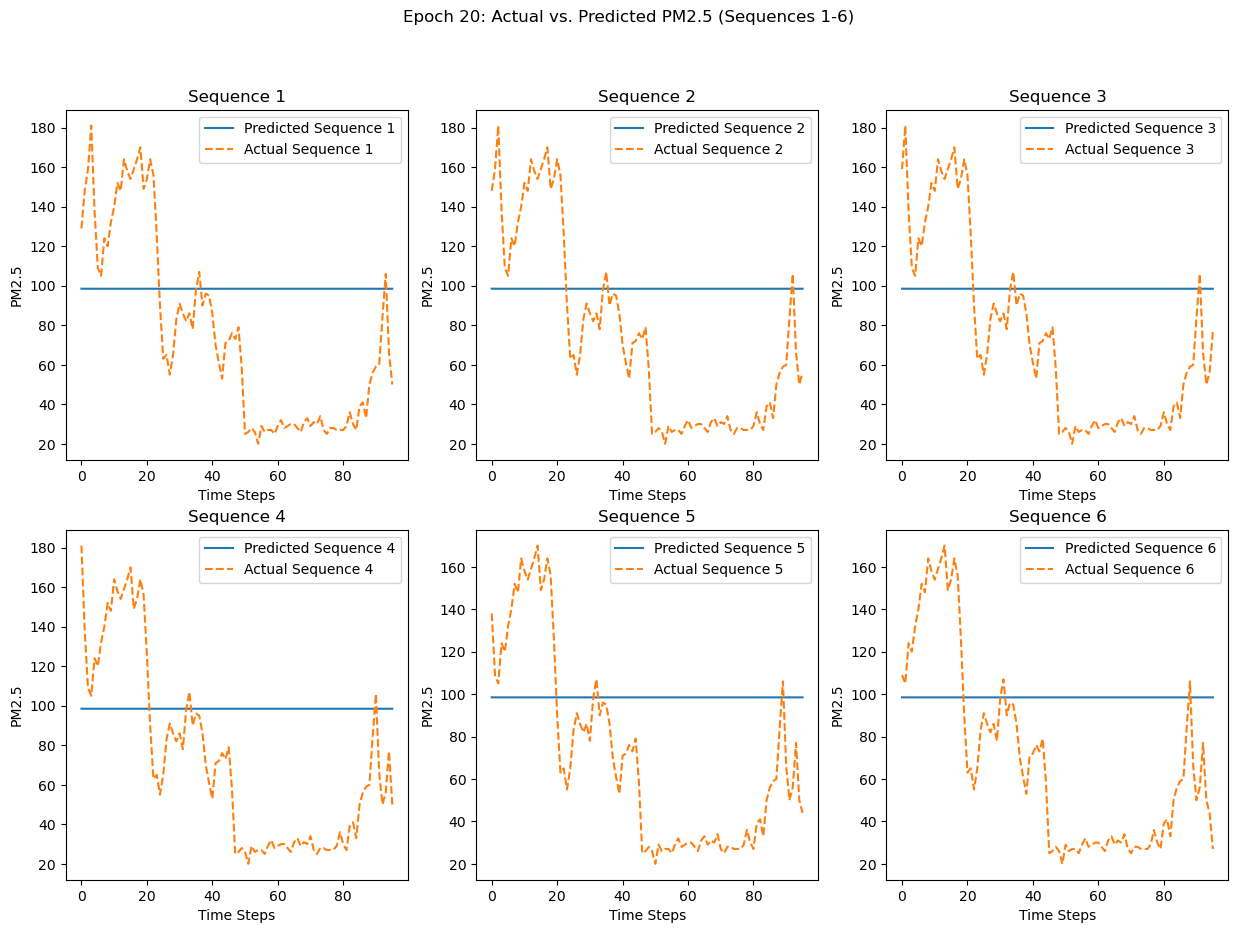

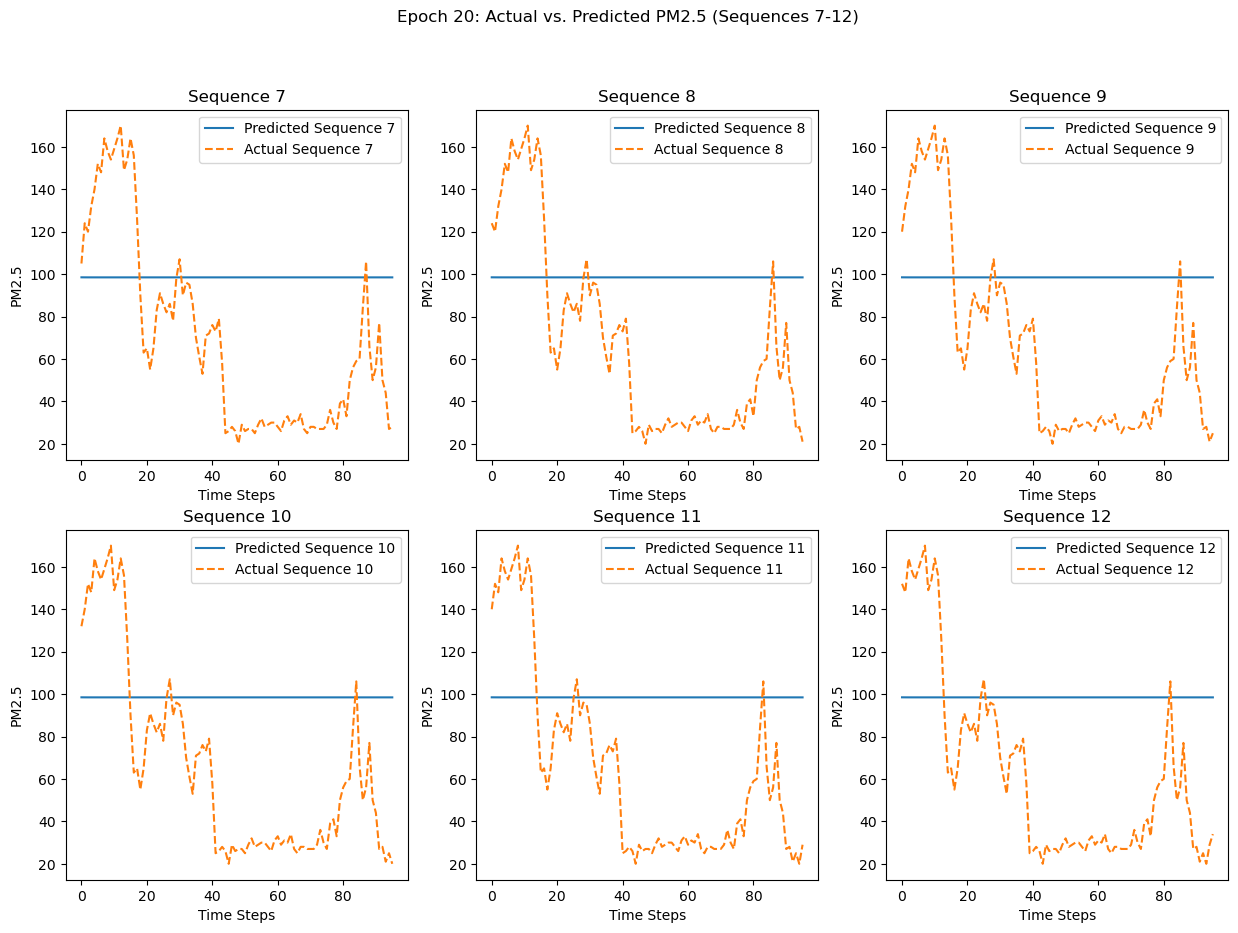

Epoch [21/22], Loss: 1.0049
Epoch [22/22], Loss: 1.0048


In [300]:
#Train the model
num_epochs = params.num_epochs
#num_epochs = 10

# Initialize list to store loss values
loss_values = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for data, labels in train_loader:
        data, labels = data.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)

        # Compute the loss (squeeze the outputs so they match the shape of labels)
        loss = criterion(outputs.squeeze(-1), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)  # Store average loss for this epoch

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

    # Every 10 epochs, generate plots for the fixed sequences
    if (epoch + 1) % 20 == 0:
        model.eval()  # Switch to evaluation mode for generating predictions
        with torch.no_grad():
            predictions = model(fixed_sequences)

        # Mean and standard deviation of the scaled values
        means = scaler.mean_
        stds = scaler.scale_
        
        # Reverse the standardization to get predictions and actual values in the original scale
        predictions_np = predictions.squeeze(-1).cpu().numpy() * stds[pm_index] + means[pm_index]  # Reverse standardization
        actual_np = fixed_labels.cpu().numpy() * stds[pm_index] + means[pm_index]  # Reverse standardization for actual values

         # Create two images, each with 6 subplots
        fig1, axs1 = plt.subplots(2, 3, figsize=(15, 10))  # First image, 2 rows x 3 columns
        fig2, axs2 = plt.subplots(2, 3, figsize=(15, 10))  # Second image, 2 rows x 3 columns
    
        for i in range(6):  # First 6 sequences in the first figure
            ax = axs1[i // 3, i % 3]  # Access subplot in grid
            ax.plot(predictions_np[i], label=f'Predicted Sequence {i+1}')
            ax.plot(actual_np[i], label=f'Actual Sequence {i+1}', linestyle='dashed')
            ax.set_title(f'Sequence {i+1}')
            ax.set_xlabel('Time Steps')
            ax.set_ylabel('PM2.5')
            ax.legend()
    
        for i in range(6, 12):  # Next 6 sequences in the second figure
            ax = axs2[(i - 6) // 3, (i - 6) % 3]  # Access subplot in grid
            ax.plot(predictions_np[i], label=f'Predicted Sequence {i+1}')
            ax.plot(actual_np[i], label=f'Actual Sequence {i+1}', linestyle='dashed')
            ax.set_title(f'Sequence {i+1}')
            ax.set_xlabel('Time Steps')
            ax.set_ylabel('PM2.5')
            ax.legend()
    
        # Display the two images with 6 subplots each
        fig1.suptitle(f'Epoch {epoch + 1}: Actual vs. Predicted PM2.5 (Sequences 1-6)')
        fig2.suptitle(f'Epoch {epoch + 1}: Actual vs. Predicted PM2.5 (Sequences 7-12)')

        plt.show()  # Show the first figure
        plt.show()  # Show the second figure
    
        model.train()  # Switch back to training mode

In [301]:
print("scaler mean is:", means)
print("scaler std dev is:", stds)

scaler mean is: [2.19287170e+00 5.57413691e+01 4.35427764e-01 2.47816423e+01
 9.84741813e+01 1.01592339e+03 1.23591438e+01 1.12612613e-01
 3.26790294e-01 3.56381929e-01 7.87729335e-02]
scaler std dev is: [14.52707105 26.01745419  4.90531689 49.25149802 90.62108743 10.58980477
 12.51572309  0.31611867  0.46903987  0.4789299   1.01665514]


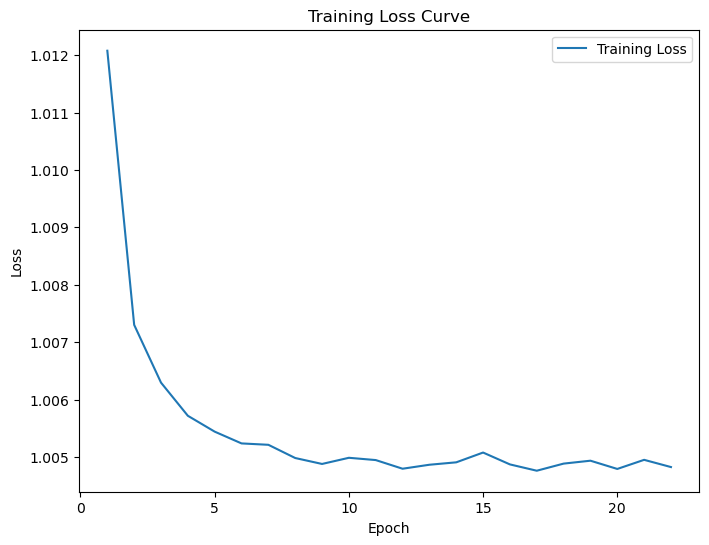

In [302]:
# Plot the loss curve after training
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


Create a DataLoader for the validation set

In [303]:
val_dataset = TimeSeriesDataset(valdata_tensor, val_labels_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size = params.batch_size, shuffle=False)

VALIDATING THE MODEL

In [304]:
# Set the model to evaluation mode
model.eval()

# Initialize a list to store predictions
all_predictions = []
all_actual_labels = []

# Initialize total loss for calculating MSE over the validation set
total_val_loss = 0.0

# Make predictions on the validation dataset using the DataLoader
with torch.no_grad():
    for data, labels in val_loader:
        #data_tensor, _ = data  # We only need the features for prediction
        #predictions = model(data_tensor.to('cuda' if torch.cuda.is_available() else 'cpu'))
        data, labels = data.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Forward pass to get predictions
        predictions = model(data)
        
        # Compute the validation loss (MSE)
        val_loss = criterion(predictions.squeeze(-1), labels)
        
        # Accumulate the total validation loss
        total_val_loss += val_loss.item()
        
        # Store predictions and actual labels for later analysis or metrics calculation
        all_predictions.append(predictions.cpu().numpy())  # Move predictions to CPU and store
        all_actual_labels.append(labels.cpu().numpy())     # Move labels to CPU and store

# Calculate the average MSE over the entire validation set
avg_val_loss = total_val_loss / len(val_loader)
print(f'Validation Loss (MSE): {avg_val_loss:.4f}')

# Concatenate all predictions and actual labels into a single array
val_predictions = np.concatenate(all_predictions, axis=0)
val_actual_labels = np.concatenate(all_actual_labels, axis=0)

        
        
        
       # all_predictions.append(predictions.cpu().numpy())  # Append to list

## Concatenate all predictions into a single array
#val_predictions = np.concatenate(all_predictions, axis=0)

Validation Loss (MSE): 1.2459


In [305]:
# Step 2: Reverse Standardization for Predictions
means = scaler.mean_
stds = scaler.scale_

# Flatten predictions
predictions_np = val_predictions.squeeze(-1)
predictions_original_scale = predictions_np * stds[pm_index] + means[pm_index]  # Assuming PM2.5 is the first column

## Step 3: Reverse Standardization for Actual PM2.5 Labels
#actual_labels_np = val_labels_tensor.numpy()
#actual_labels_original_scale = actual_labels_np * stds[0] + means[0]  # Same column assumption

# Step 3: Reverse Standardization for Actual PM2.5 Labels
actual_labels_original_scale = val_actual_labels * stds[pm_index] + means[pm_index]



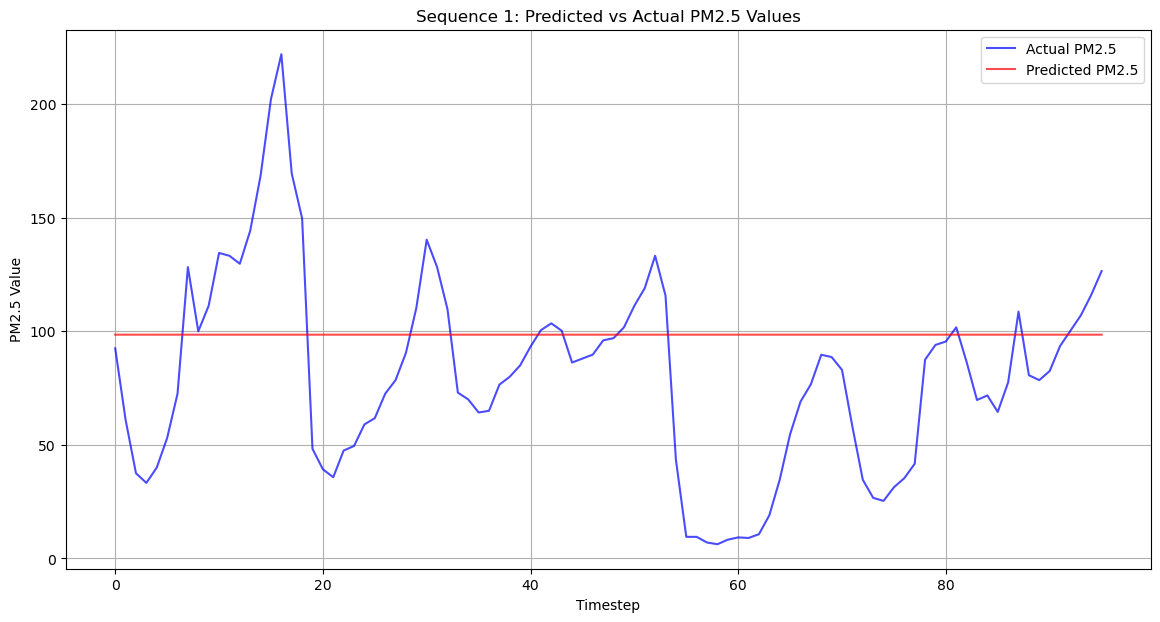

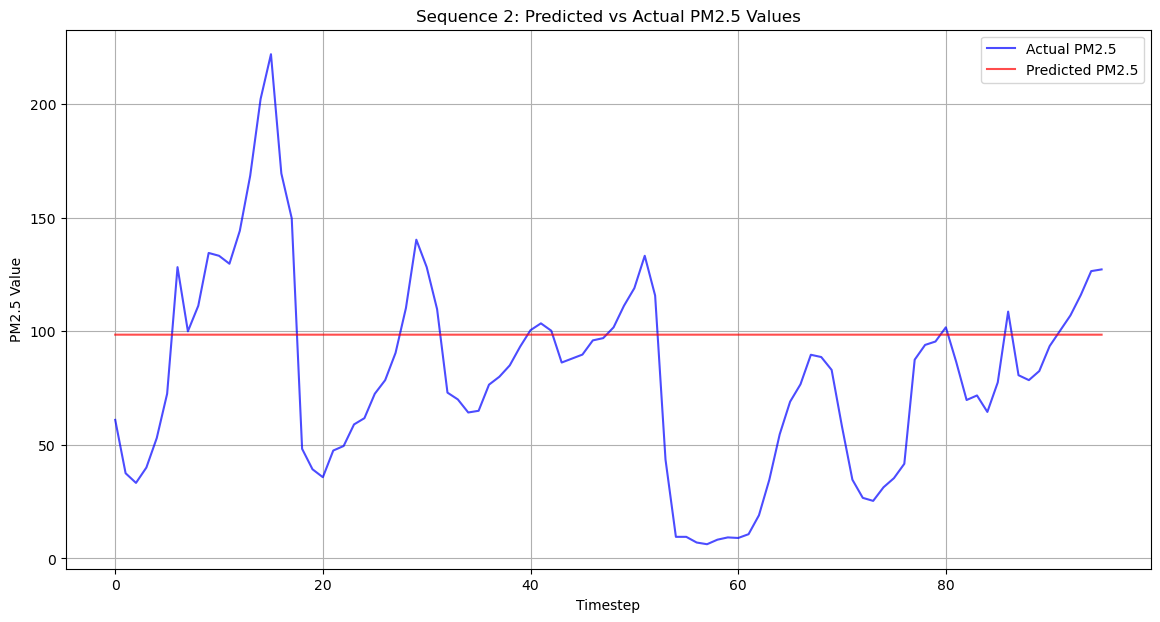

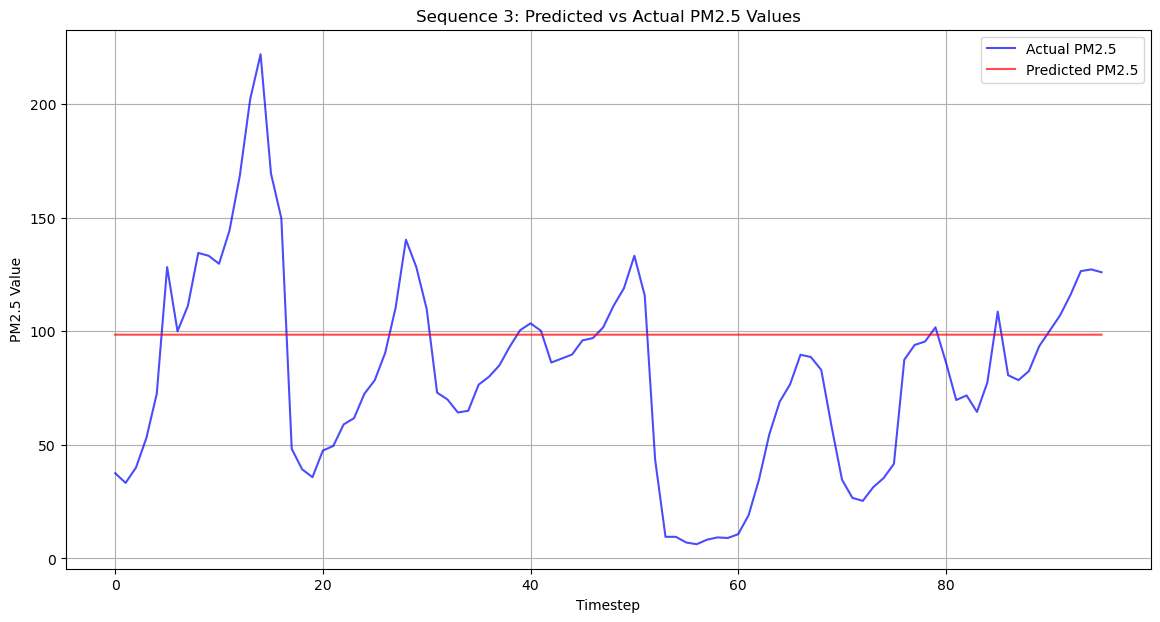

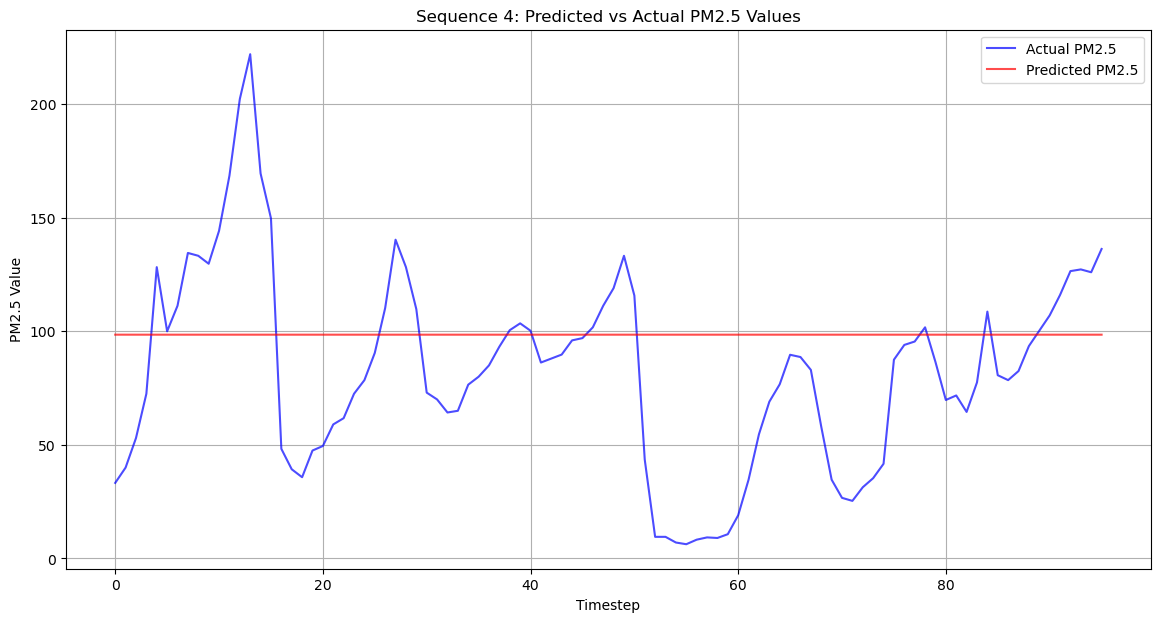

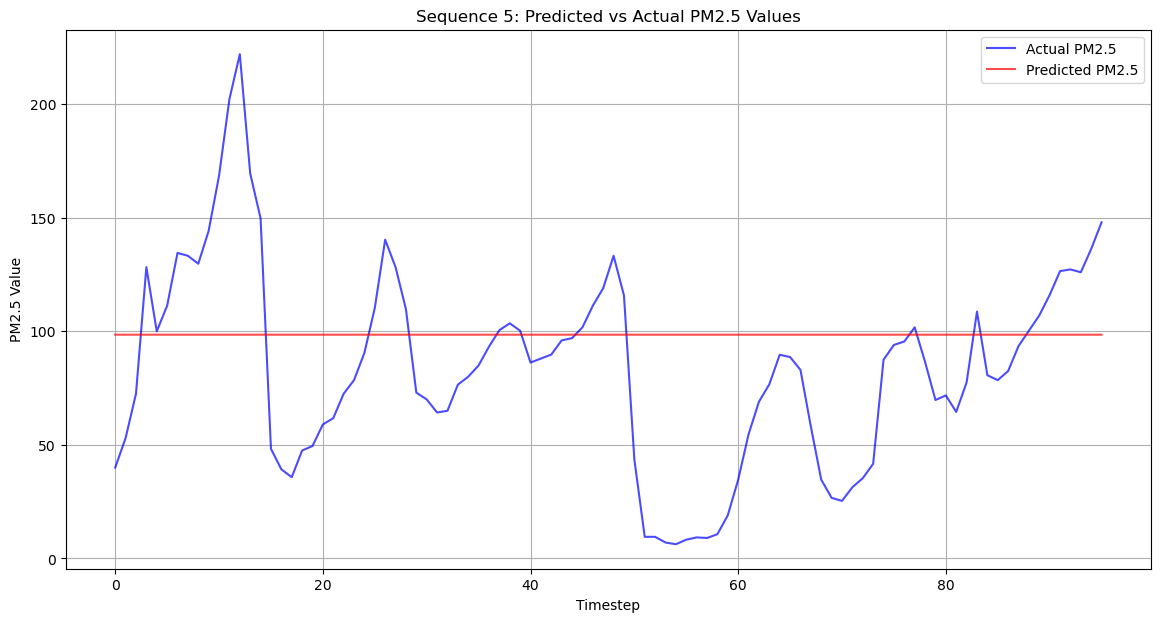

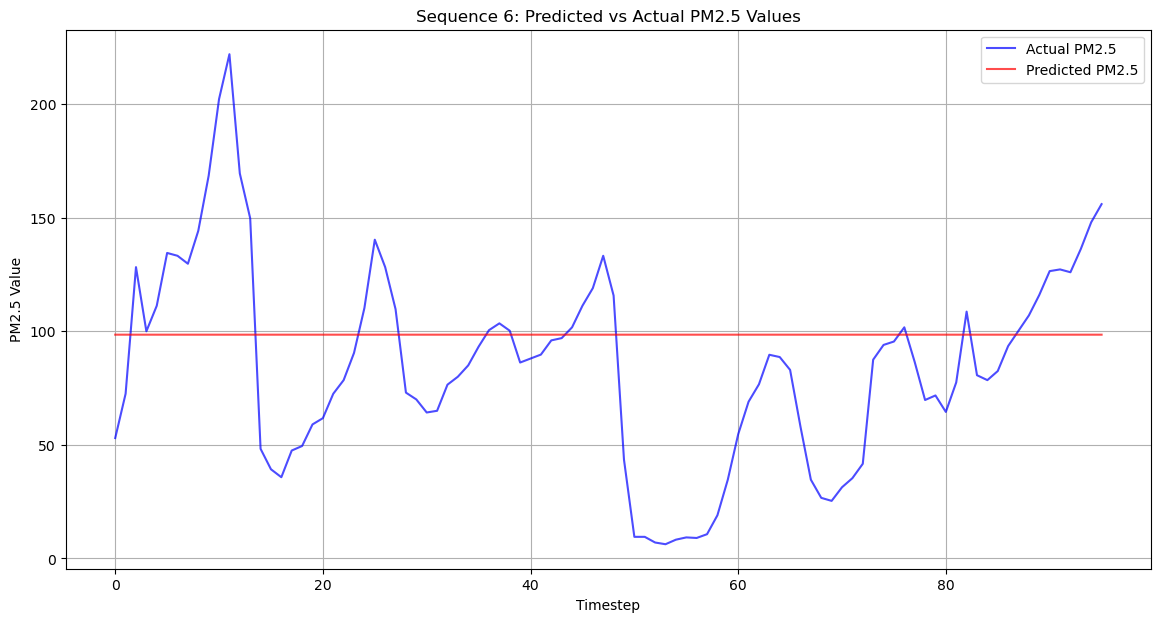

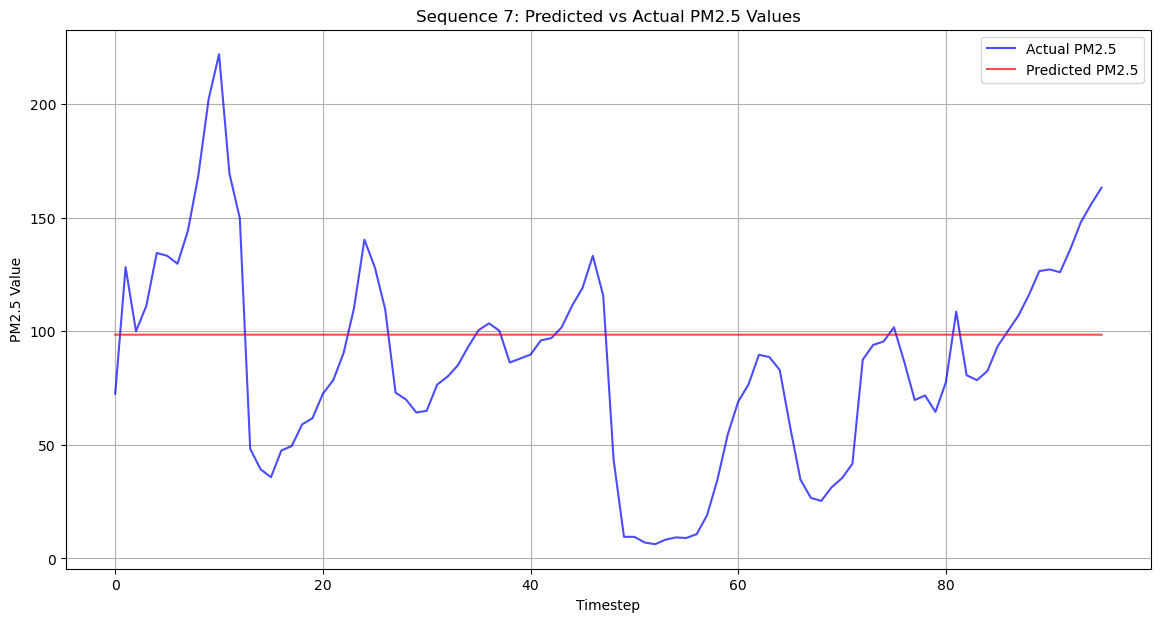

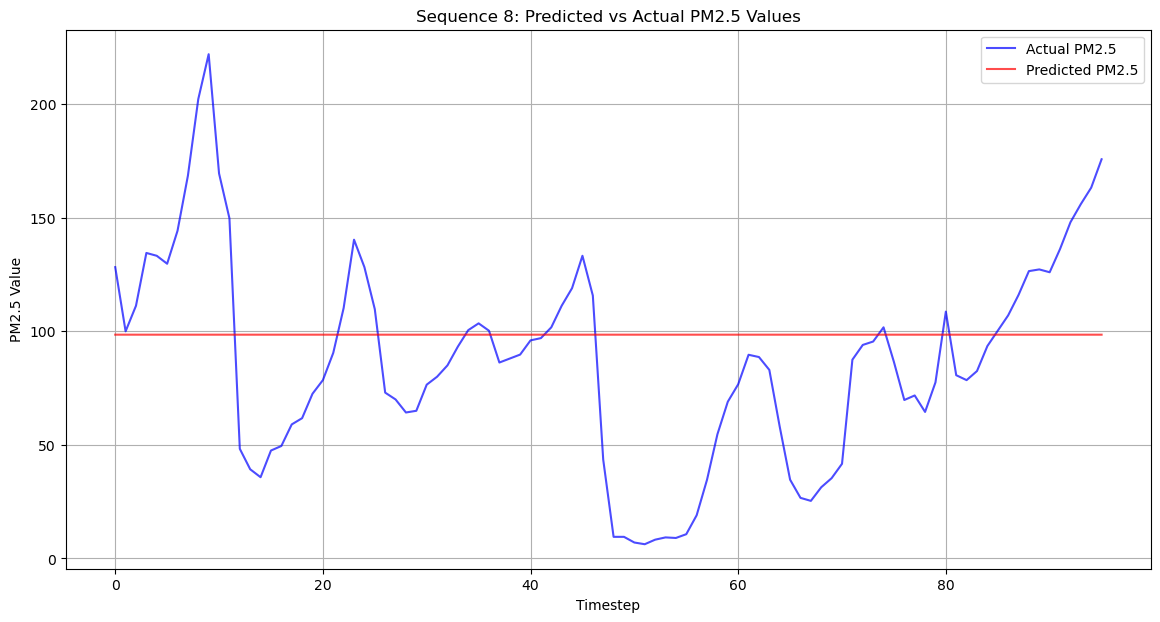

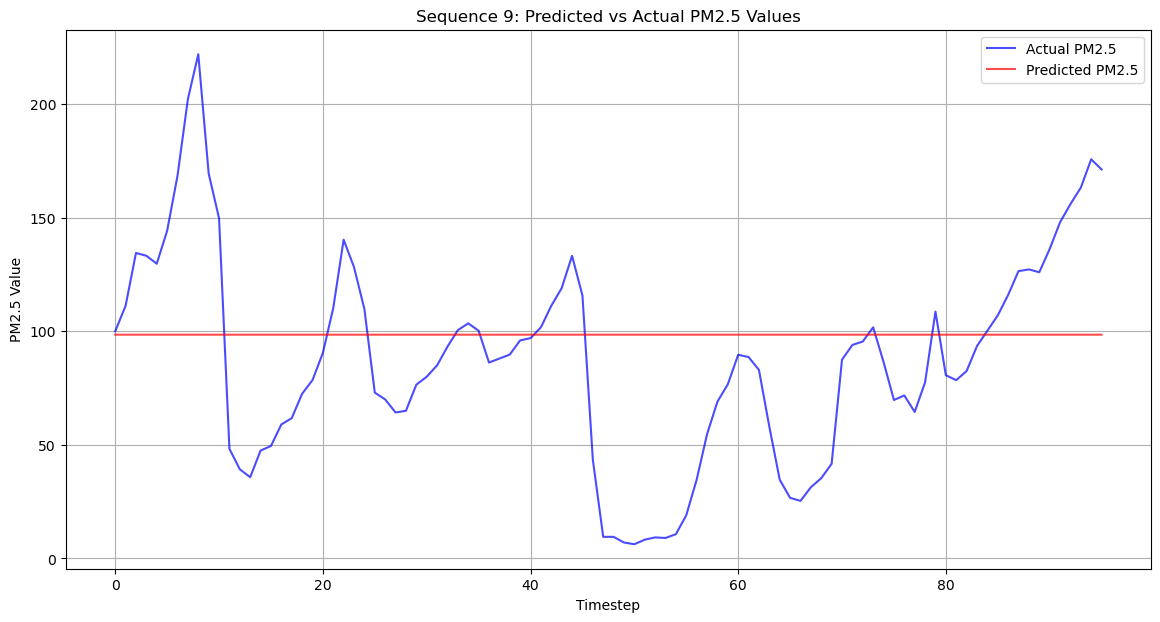

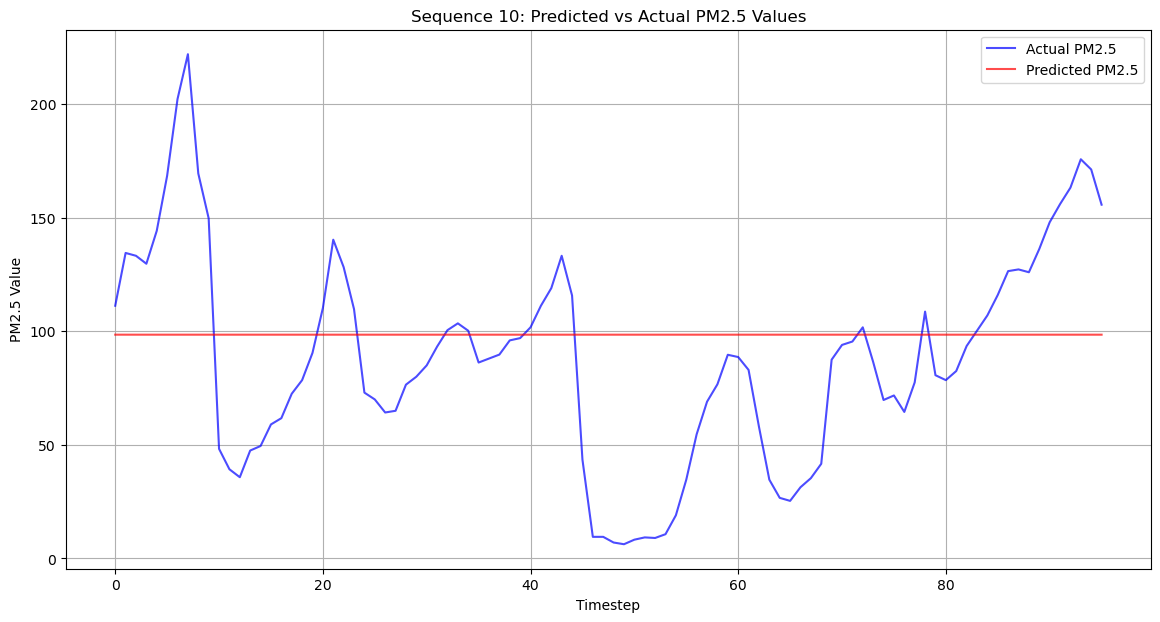

In [306]:
import matplotlib.pyplot as plt
from IPython.display import display

# Number of sequences to plot
num_sequences = 10

# Loop through the first 10 sequences and create individual plots
for i in range(num_sequences):
    plt.figure(figsize=(14, 7))
    
    # Plot actual PM2.5 values
    plt.plot(actual_labels_original_scale[i], label='Actual PM2.5', color='blue', alpha=0.7)
    
    # Plot predicted PM2.5 values
    plt.plot(predictions_original_scale[i], label='Predicted PM2.5', color='red', alpha=0.7)
    
    # Set title and labels
    plt.title(f'Sequence {i+1}: Predicted vs Actual PM2.5 Values')
    plt.xlabel('Timestep')
    plt.ylabel('PM2.5 Value')
    
    # Show legend and grid
    plt.legend()
    plt.grid(True)
    
    # Display the plot inline
    display(plt.gcf())  # This will display the plot inline in notebooks
    
    # Close the current figure after displaying to avoid overlap
    plt.close()
